# Analysis of the LCCS validation data

Validation data was gathered in 2020 to support the product release.

Minor caveats up front:
 - There is no unequivocal ground truth; this was a desktop validation process based on aerial imagery and products derived from satellite imagery (i.e. annual geomedians, WOfS statistics, NDVI time series plots). Validators were directed to consider specific WOfS/NDVI thresholds.
 - The validation was never blind, and points were pre-sorted by predicted class. Different validators examined different spatial clusters.

## Preliminaries

In [1]:
import geopandas, pandas, numpy as np, glob, matplotlib.pyplot as plt, cartopy
import scipy.spatial.distance, scipy.stats, rasterio

### Loading data

In [2]:
pattern = '/g/data/r78/LCCS_Aberystwyth/validation/validation_comparison_completed/validation_comparison_*.shp'
filenames = sorted(glob.glob(pattern))
names = [filename.split('_')[-1][:-4] for filename in filenames]
subtables = [geopandas.read_file(filename) for filename in filenames]
comparison = pandas.concat([subtables[0].classified] + 
                     [df.output.rename(name) for name, df in zip(names, subtables)], axis=1)
comparison

,classified,ChrisO,Eloise,Gabrielle,Norman,Richard,belle,ben,Cate,erin,erinv2,sean
0,111,111,111,111,111,111,111,111,111,111,111,111
1,111,112,112,112,112,112,112,112,112,112,112,112
2,111,111,111,m,111,111,111,111,111,111,111,111
3,111,111,111,111,111,111,111,111,111,111,111,111
4,111,112,112,112,112,112,112,112,112,112,112,112
...,...,...,...,...,...,...,...,...,...,...,...,...
139,220,220,220,220,220,220,220,220,220,220,220,220
140,220,220,220,220,220,220,220,220,220,220,220,220
141,220,124,220,220,220,220,220,220,220,220,112,220
142,220,220,220,220,220,220,220,220,220,220,220,220


In [3]:
def gather(year):
    pattern = '/g/data/r78/LCCS_Aberystwyth/validation/' + year + '/complete_clusters/validation_*.shp'
    return pandas.concat([geopandas.read_file(filename) for filename in glob.glob(pattern)], ignore_index=True)
before = gather('2010')
after = gather('2015')

### Clean out invalid or ambiguous classifications

For about a hundred points in either epoch, humans did not singly assign a valid category. Such points will be excluded from the assessment of the classifier performance.

There are also thirteen clusters which each contain a point that lacks the "processed" flag. (2010: 14, 15, 38, 50; 2015: 7, 17, 30, 39, 40, 47, 52, 56, 58.) Furthermore, 2015's cluster 1 lacks the flag for 60% of its points. 

In [4]:
for table in [before, after]:
    criteria = (table.processed != '1') | table[['classified', 'output']].isin(list('um01')).any(axis=1)
    table.drop(table.index[criteria], inplace=True)

In [5]:
both = pandas.concat([before, after], ignore_index=True)
both

,classified,output,processed,cluster,geometry
0,111,112,1,40,POINT (1474537.500 -1899512.500)
1,111,111,1,40,POINT (1482862.500 -2082512.500)
2,111,111,1,40,POINT (1454387.500 -1997087.500)
3,112,112,1,40,POINT (1382687.500 -2172612.500)
4,112,112,1,40,POINT (1150087.500 -2022737.500)
...,...,...,...,...,...
11622,215,215,1,17,POINT (-1503187.500 -3729412.500)
11623,216,216,1,17,POINT (-1253587.500 -3692637.500)
11624,220,220,1,17,POINT (-1510162.500 -3691712.500)
11625,220,220,1,17,POINT (-1398362.500 -3851587.500)


### Matching samples between years

There are two complications:
 - Some clusters (viz., 6 & 9 for 2010) have coordinate jitter, probably due to spurious reprojection.
 - Some clusters (viz., 47, 41 & 1 for 2010) contain a point that is absent in the other epoch.

In [6]:
# fix coordinate jitter
before.geometry = geopandas.points_from_xy(before.geometry.x.round(1), before.geometry.y.round(1))

In [7]:
join = pandas.merge(before, after, on='geometry', suffixes=['2010', '2015'])
join

,classified2010,output2010,processed2010,cluster2010,geometry,classified2015,output2015,processed2015,cluster2015
0,111,112,1,40,POINT (1474537.500 -1899512.500),111,112,1,13
1,111,111,1,40,POINT (1482862.500 -2082512.500),111,111,1,13
2,111,111,1,40,POINT (1454387.500 -1997087.500),111,112,1,13
3,112,112,1,40,POINT (1382687.500 -2172612.500),112,112,1,13
4,112,112,1,40,POINT (1150087.500 -2022737.500),112,112,1,13
...,...,...,...,...,...,...,...,...,...
5634,124,124,1,17,POINT (1121637.500 -1283862.500),124,124,1,32
5635,124,124,1,17,POINT (1070412.500 -1351687.500),124,124,1,32
5636,220,220,1,17,POINT (1092112.500 -1395637.500),220,220,1,32
5637,220,220,1,17,POINT (1096887.500 -1332962.500),220,220,1,32


### Grouping by climate region

This will be added as a column to the tables.

In [8]:
with rasterio.open('/g/data/r78/LCCS_Aberystwyth/brl654/koppen/Beck_KG_V1_present_0p0083.tif') as f:
    for table in [join, both]:
        pts = table.geometry.to_crs(f.crs)
        table['region'] = [x[0] for x in rasterio.sample.sample_gen(f, zip(pts.x, pts.y))]

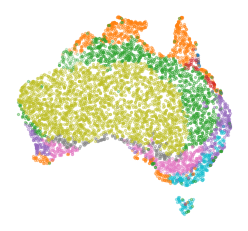

In [9]:
for i in both.region.unique():
    both.query('region==' + str(i)).plot(alpha=0.2, ax=plt.gca(), markersize=5)
plt.gca().axis("off"); None

### Useful functions or definitions

In [10]:
extent = [both.geometry.x.min(), both.geometry.x.max(), both.geometry.y.min(), both.geometry.y.max()]

## Comparison between validators

Analysis of the subset that enables comparison between multiple individuals.

In [11]:
dist = scipy.spatial.distance.pdist(comparison.replace(['m', 'u'], [0, 1]).values.T, 'jaccard')
dist = scipy.spatial.distance.squareform(dist)
dist = pandas.DataFrame((1-dist) * 100, columns=comparison.columns, index=comparison.columns)

dist.round(3).style.background_gradient(cmap='cividis_r', axis=None).set_precision(2)

,classified,ChrisO,Eloise,Gabrielle,Norman,Richard,belle,ben,Cate,erin,erinv2,sean
classified,100.00,75.00,83.33,84.72,84.72,84.72,82.64,79.17,87.50,93.75,81.25,83.33
ChrisO,75.00,100.00,83.92,82.64,85.42,77.78,84.72,80.42,84.03,79.17,87.50,81.25
Eloise,83.33,83.92,100.00,89.58,90.97,86.11,90.28,84.72,90.97,85.42,89.58,84.03
Gabrielle,84.72,82.64,89.58,100.00,92.36,85.42,88.89,88.89,93.71,88.19,89.58,89.58
Norman,84.72,85.42,90.97,92.36,100.00,86.81,90.28,90.28,91.67,86.81,91.67,89.58
Richard,84.72,77.78,86.11,85.42,86.81,100.00,84.03,86.11,86.11,86.11,84.03,85.42
belle,82.64,84.72,90.28,88.89,90.28,84.03,100.00,83.33,91.67,85.42,90.97,86.11
ben,79.17,80.42,84.72,88.89,90.28,86.11,83.33,100.00,87.50,81.94,85.42,89.58
Cate,87.50,84.03,90.97,93.71,91.67,86.11,91.67,87.50,100.00,89.58,91.67,89.58
erin,93.75,79.17,85.42,88.19,86.81,86.11,85.42,81.94,89.58,100.00,87.41,88.19


## Full validation statistics

Beware that the dataset was stratified. This suggests that false discovery rate is valid, but sensitivity is technically not. (That is, the sampling was deliberately biased to balance representation of predicted classes, however the true spatial distributions could differ from the corresponding predictions.) In particular, the false negatives of uncommon classes may be undersampled (and the false negatives of common classes may be oversampled).

In [12]:
correct = both.classified == both.output
correct.mean() * 100 # Overall accuracy (%)

79.61641007998624

In [13]:
TP = both[correct].groupby('classified').size()
FP = both[~correct].groupby('classified').size()
FN = both[~correct].groupby('output').size()
TN = len(both) - (TP + FP + FN)

pandas.concat([
    (TP / (TP + FN)).rename('sensitivity'),
    (TN / (TN + FP)).rename('specificity'),
    (FP / (TP + FP)).rename('false discovery')
], axis=1).rename_axis('class').round(3) * 100

,sensitivity,specificity,false discovery
class,,,
111,80.8,94.4,45.1
112,77.6,86.2,10.3
124,93.2,99.9,2.0
215,85.1,99.9,3.4
216,76.6,88.7,40.7
220,97.0,99.7,6.5


It might be useful to also look at the matrix of missclassifications, to understand which category pairs are difficult to distinguish.

### Spatial variability

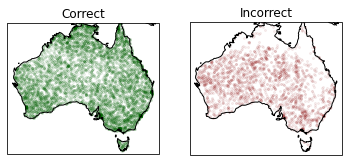

In [14]:
# crude plot
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection=cartopy.crs.epsg(3577)))
ax1.add_feature(cartopy.feature.COASTLINE)
ax2.add_feature(cartopy.feature.COASTLINE)
both[correct].plot(ax=ax1, color='darkgreen', alpha=0.06, markersize=4) # good points (green)
both[~correct].plot(ax=ax2, color='darkred', alpha=0.06, markersize=4) # bad points (red)
ax1.set_title('Correct')
ax2.set_title('Incorrect')
None

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


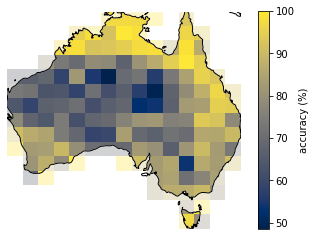

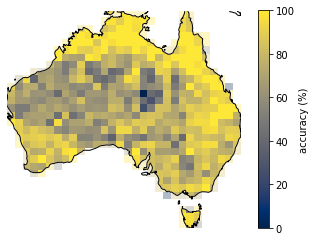

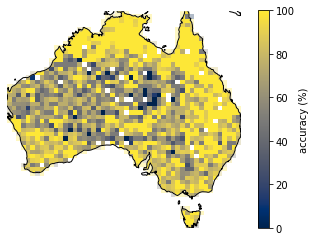

In [15]:
def histmap(nbins):
    def hist(table):
        return np.histogram2d(table.geometry.x, table.geometry.y, bins=nbins, range=[extent[:2], extent[2:]])[0]
    good = hist(both[correct])
    bad = hist(both[~correct])
    total = hist(both)
    assert (good + bad == total).all()
    
    ax = plt.gcf().add_subplot(1, 1, 1, projection=cartopy.crs.epsg(3577), frameon=False)
    im = ax.imshow(100 * (good / total).T, extent=extent, origin='lower', cmap='cividis', interpolation='nearest')
    plt.colorbar(im).set_label('accuracy (%)')
    ax.add_feature(cartopy.feature.OCEAN, zorder=100, facecolor='w', alpha=0.7)
    ax.add_feature(cartopy.feature.COASTLINE, zorder=110)
    
plt.figure(); histmap(15)
plt.figure(); histmap(30)
plt.figure(); histmap(50)

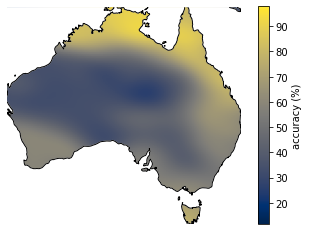

In [16]:
res = 100
coords = np.vstack([c.ravel() for c in np.mgrid[extent[0]:extent[1]:res*1j, extent[2]:extent[3]:res*1j]])

def density(table):
    samples = np.vstack([table.geometry.x, table.geometry.y])
    return scipy.stats.gaussian_kde(samples)(coords).reshape((res, res))
good = density(both[correct])
bad = density(both[~correct])

ax = plt.gcf().add_subplot(1, 1, 1, projection=cartopy.crs.epsg(3577), frameon=False)
ax.add_feature(cartopy.feature.OCEAN, zorder=100, facecolor='w')
ax.add_feature(cartopy.feature.COASTLINE, zorder=110)
im = ax.imshow(100 * (good / (good + bad)).T, extent=extent, origin='lower', cmap='cividis')
plt.colorbar(im).set_label('accuracy (%)')
None

## Transition statistics

If considering *net change* involving an uncommon class, beware that the samples were pre-stratified on the basis of one epoch only.

In [17]:
perfect = (join.output2010 == join.classified2010) & (join.output2015 == join.classified2015)
perfect.mean() * 100 # What portion was simultaneously accurate for both epochs?

66.55435360879589

In [18]:
machine = dict(classified2010='2010', classified2015='2015')
human = dict(output2010='2010', output2015='2015')

transitions = pandas.concat([
    join.rename(columns=machine).groupby(['2010', '2015']).size().rename('classifier_count'),
    join.rename(columns=human).groupby(['2010', '2015']).size().rename('validator_count'),
    join[perfect].rename(columns=human).groupby(['2010', '2015']).size().rename('consensus')
], axis=1).fillna(0).astype(int)

In [19]:
assert transitions.classifier_count.sum() == len(join)
assert transitions.validator_count.sum() == len(join)
assert transitions.consensus.sum() == perfect.sum()
assert (transitions.consensus <= transitions.classifier_count).all()
assert (transitions.consensus <= transitions.validator_count).all()

# True positives, false negatives, etc
TP = transitions.consensus
FP = transitions.classifier_count - TP
FN = transitions.validator_count - TP
TN = len(join) - (TP + FP + FN)

for i in [TP, FP, FN, TN]:
    assert (i >= 0).all()

transitions['sensitivity'] = (TP / (TP + FN)).round(3) * 100
transitions['specificity'] = (TN / (TN + FP)).round(3) * 100
transitions['false discovery'] = (FP / (TP + FP)).round(3) * 100

transitions

classifier_count  validator_count  consensus  sensitivity  \
2010 2015                                                              
111  111                352              334        216         64.7   
     112                165               42         11         26.2   
     215                  2                0          0          NaN   
     216                 88                1          1        100.0   
     220                  8                0          0          NaN   
112  111                262              152         87         57.2   
     112               2388             2862       2132         74.5   
     124                  2               14          1          7.1   
     215                 46               35         25         71.4   
     216                500              486        200         41.2   
     220                 31                6          3         50.0   
124  112                  0                5          0          0.0   
     124                256              258        249         96.5   
     215                  0                1          0          0.0   
     216                  0                1          0          0.0   
     220                  2                4          1         25.0   
215  215                152              210        143         68.1   
     216                  0                2          0          0.0   
216  111                 54                3          2         66.7   
     112                181              422         84         19.9   
     124                  0                2          0          0.0   
     215                 57                9          5         55.6   
     216                826              506        354         70.0   
     220                 38               56         33         58.9   
220  111                  1                2          1         50.0   
     112                  9                6          4         66.7   
     124                 10               11          5         45.5   
     216                 15               19         13         68.4   
     220                194              190        183         96.3   

           specificity  false discovery  
2010 2015                                
111  111          97.4             38.6  
     112          97.2             93.3  
     215         100.0            100.0  
     216          98.5             98.9  
     220          99.9            100.0  
112  111          96.8             66.8  
     112          90.8             10.7  
     124         100.0             50.0  
     215          99.6             45.7  
     216          94.2             60.0  
     220          99.5             90.3  
124  112         100.0              NaN  
     124          99.9              2.7  
     215         100.0              NaN  
     216         100.0              NaN  
     220         100.0             50.0  
215  215          99.8              5.9  
     216         100.0              NaN  
216  111          99.1             96.3  
     112          98.1             53.6  
     124         100.0              NaN  
     215          99.1             91.2  
     216          90.8             57.1  
     220          99.9             13.2  
220  111         100.0              0.0  
     112          99.9             55.6  
     124          99.9             50.0  
     216         100.0             13.3  
     220          99.8              5.7